In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
from pathlib import Path
import re

In [2]:
def get_gaps(list_freqs,gap_width_tolerance:float=0.005):
    flattened_lambdas = np.sort(np.concatenate(list_freqs))
    bands = []
    gaps_list = np.diff(flattened_lambdas)
    for i,gaps in enumerate(gaps_list):
        # max_gap_index = np.argmax(gaps)
        bandgap_lower = flattened_lambdas[i]
        bandgap_upper = flattened_lambdas[i + 1]
        gap_width = (bandgap_upper-bandgap_lower)/((bandgap_upper+bandgap_lower)/2)
        if gap_width>=gap_width_tolerance:
            bands.append([bandgap_lower,bandgap_upper,gap_width])
    return bands

In [3]:
# directory = r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250630 MPB Bands analysis\20250728_Florescu_calculations"
directory = r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250630 MPB Bands analysis\20250811_Results_res_128"


In [4]:
extracted_data = {}

for dirpath, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith(".csv") and "ak4" in filename:
            file_path = os.path.join(dirpath, filename)
            type_sim = "_".join(Path(dirpath).parts[-2:])
            file_key = Path(filename).stem + "_" + type_sim
            if file_key not in extracted_data.keys():
                extracted_data[file_key]={}
            freqs=[]
            k_points=[]
            with open(file_path, newline='') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    freqs.append(row[5:])
                    k_points.append(row[0])
                extracted_data[file_key]["freqs"] = freqs
                extracted_data[file_key]["k_points"] = k_points

In [5]:
#directory to save figures
gap_list = {"Elliptical":{},"Circular":{}}
save_fig_path = "./20250811_Results_res_128_pictures_2"
os.makedirs(save_fig_path,exist_ok=True)
for item in extracted_data.keys():
    if len(extracted_data[item]["freqs"])==0:
        continue
    freqs = np.array(extracted_data[item]["freqs"][1:],dtype=float)
    k_points= np.array(extracted_data[item]["k_points"][1:],dtype=float)

    for freq_item in freqs.T:
        plt.scatter(k_points-1,(freq_item), color="blue",facecolors='none')

    tick_labs = [r'$\Gamma$', r'$X$', r'$M$', r'$R$',r'$\Gamma$', r'$M$',r'$X$',r'$R$']
    plt.ylabel('frequency (c/a)', size=16)
    points_in_between = 0
    tick_locs = [i*points_in_between+i for i in range(len(tick_labs))]
    title = item[item.index("eps_")+len("eps_"):].strip()
    ff = float(re.search(r'ff_([+-]?\d+(?:\.\d+)?)', title).group(1))
    n = float(re.search(r'index_([+-]?\d+(?:\.\d+)?)', title).group(1))
    # gap = get_gaps(freqs[freqs>1][np.newaxis,:])
    gap = np.array(get_gaps(freqs[:,300:]))
    try:
        gap_item = gap[np.argmax(gap[:, 2])]
    except:
        gap_item=[0,0,0]

    if ff in [0.05,0.0502]:
        gap_item=[0,0,0]
    plt.fill_between(k_points-1,gap_item[0],gap_item[1], color='red', alpha=0.2)
    plt.text(0.5,((gap_item[0]+gap_item[1])/2), rf'$\Delta \omega / \omega_0 = {gap_item[2]*100 :.2f}$%', fontsize = 12)

    plt.grid(True)
    plt.xticks(tick_locs, tick_labs)
    if gap_item[0]>0:
        plt.ylim(gap_item[0]-0.1,gap_item[1]+0.1)
    # plt.xlim(tick_locs[0],tick_locs[1])
    plt.xlim(-1,1.5)
    
    plt.title(title)
    if "Elliptical" in title:
        if ff not in gap_list['Elliptical']:
            gap_list['Elliptical'][ff] = {"gaps":[],"n":[],"gap_center":[]}
        gap_list['Elliptical'][ff]["gaps"].append(gap_item[2])
        gap_list['Elliptical'][ff]["gap_center"].append((gap_item[0]+gap_item[1])/2)
        gap_list['Elliptical'][ff]["n"].append(n)
        os.makedirs(f"{save_fig_path}/Elliptical/n_{n}",exist_ok=True)
        # plt.savefig(rf"{save_fig_path}/Elliptical/n_{n}/{title}.png")
    else: 
        if ff not in gap_list['Circular']:
            gap_list['Circular'][ff] = {"gaps":[],"n":[],"gap_center":[]}
        gap_list['Circular'][ff]["gaps"].append(gap_item[2])
        gap_list['Circular'][ff]["gap_center"].append((gap_item[0]+gap_item[1])/2)
        gap_list['Circular'][ff]["n"].append(n)
        os.makedirs(f"{save_fig_path}/Circular/n_{n}",exist_ok=True)
        # plt.savefig(rf"{save_fig_path}/Circular/n_{n}/{title}.png")
    plt.close()

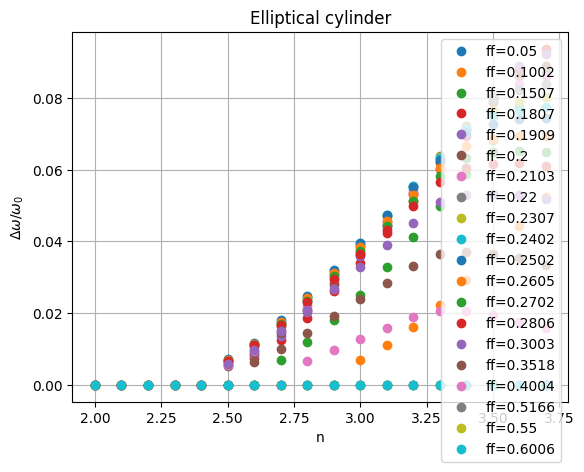

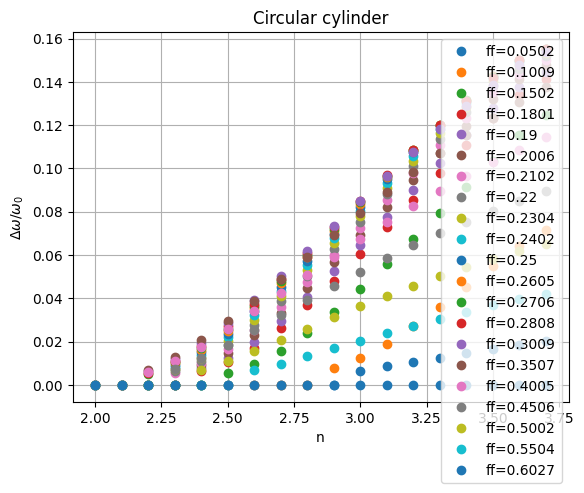

In [6]:
for type_element in gap_list.keys():
    key_sorted = sorted(list(gap_list[type_element].keys()))
    for ff in key_sorted:
        plt.plot(gap_list[type_element][ff]["n"],gap_list[type_element][ff]["gaps"],"o",label=rf"ff={ff}")
        plt.ylabel(rf'$\Delta \omega / \omega_0$')
        plt.xlabel("n")
    plt.title(rf"{type_element} cylinder")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_map_gap(data,type:str="Circular"):
    ff_list = np.array(list(data[type].keys()))
    n_list = np.array(list(data[type][ff_list[0]]["n"]))
    gap_width_array = np.array(
        [data[type][ff_item]["gaps"] for ff_item in ff_list]
    )
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ff_list,n_list)
    surf = ax.plot_surface(X, Y, gap_width_array.T, cmap='cividis', antialiased=True)

    ax.set_xlabel(r'$\phi$', labelpad=10, fontsize=12)
    ax.set_ylabel(r'$n$', labelpad=10, fontsize=12)
    fig.colorbar(surf, shrink=0.6, aspect=10, label='Bandgap Width')
    # ax.set_title(f"{type} Rods")
    plt.tight_layout()
    plt.savefig(f"{type}_rods_3d_bgw.pdf")
    plt.show()


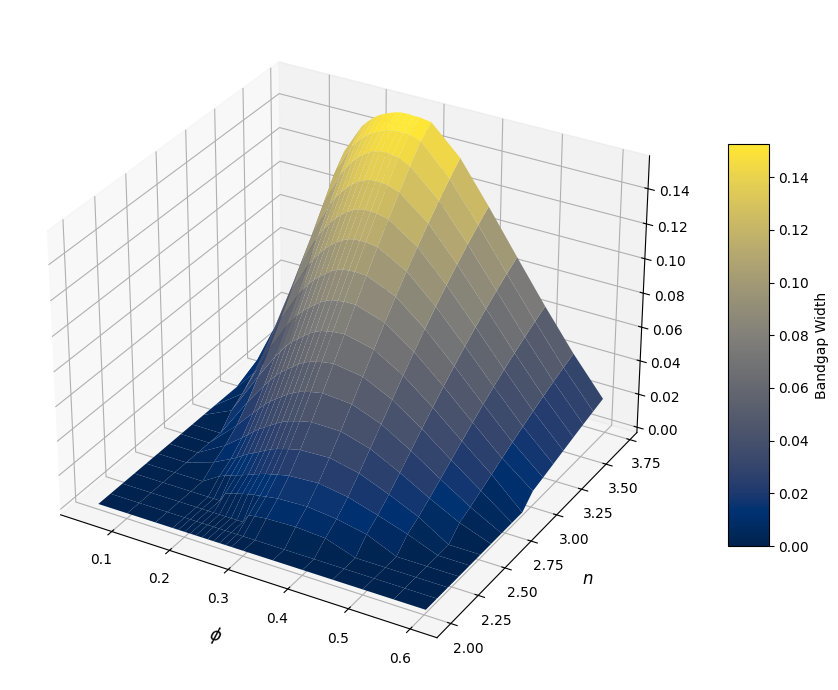

In [8]:
plot_3d_map_gap(gap_list,"Circular")

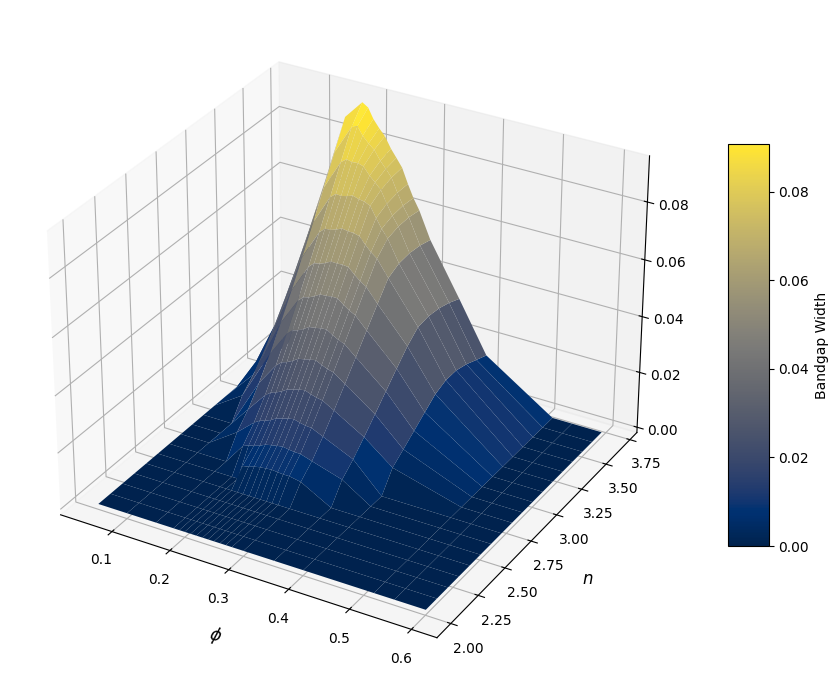

In [9]:
plot_3d_map_gap(gap_list,"Elliptical")


In [10]:
import pandas as pd
from scipy.interpolate import griddata

def plot_3d_map_gap_position(data, type: str = "Circular"):
    ff_list = np.array(list(data[type].keys()))
    n_list = np.array(list(data[type][ff_list[0]]["n"]))

    #Get values and correct units 
    gap_center_array = np.array(
        [data[type][ff_item]["gap_center"] for ff_item in ff_list]
)/14.3

    # Create a DataFrame with columns: phi, n, center, one row per (phi, n, center)
    phi_vals = []
    n_vals = []
    center_vals = []
    for i, ff in enumerate(ff_list):
        for j, n in enumerate(n_list):
            phi_vals.append(ff)
            n_vals.append(n)
            center_vals.append(gap_center_array[i, j])

    df = pd.DataFrame({
        "phi": phi_vals,
        "n": n_vals,
        "center": center_vals
    })

    # Split into zero and non-zero
    nonzero_data = df[df["center"] > 0]
    # Create 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot for non-zero values
    surf = ax.plot_trisurf(nonzero_data["phi"], nonzero_data["n"], nonzero_data["center"],
                           cmap='cividis', linewidth=0, antialiased=True,edgecolor='none')
    
    ff_list_interpolated = np.linspace(ff_list.min(), 0.5, 2000)
    n_list_interpolated = np.linspace(n_list.min(), n_list.max(), 1800)
    Phi, N = np.meshgrid(ff_list_interpolated, n_list_interpolated)

    values = (gap_center_array.flatten() == 0).astype(float)  # 1 if zero, else 0

    # Interpolate onto fine grid
    points = np.array([(phi, n) for phi in ff_list for n in n_list])

    Z_zero = griddata(points, values, (Phi, N), method='nearest')
    Z_zero = np.where(Z_zero == 1, 0, np.nan)
    ax.plot_surface(
        Phi, N, Z_zero,
        color="#f9c78c", linewidth=0, antialiased=True, edgecolor='none', alpha=0.35
    )
    ax.set_xlabel(r'$\phi$', labelpad=10, fontsize=12)
    ax.set_ylabel(r'$n$', labelpad=10, fontsize=12)
    fig.colorbar(surf, shrink=0.6, aspect=10, label=r'$\overline{d}_0/\lambda$')
    ax.set_xlim(ff_list.min(), 0.5)
    ax.set_ylim(n_list.min(), n_list.max())
    plt.tight_layout()

    
    plt.savefig(f"{type}_rods_gap_center.pdf")
    plt.show()


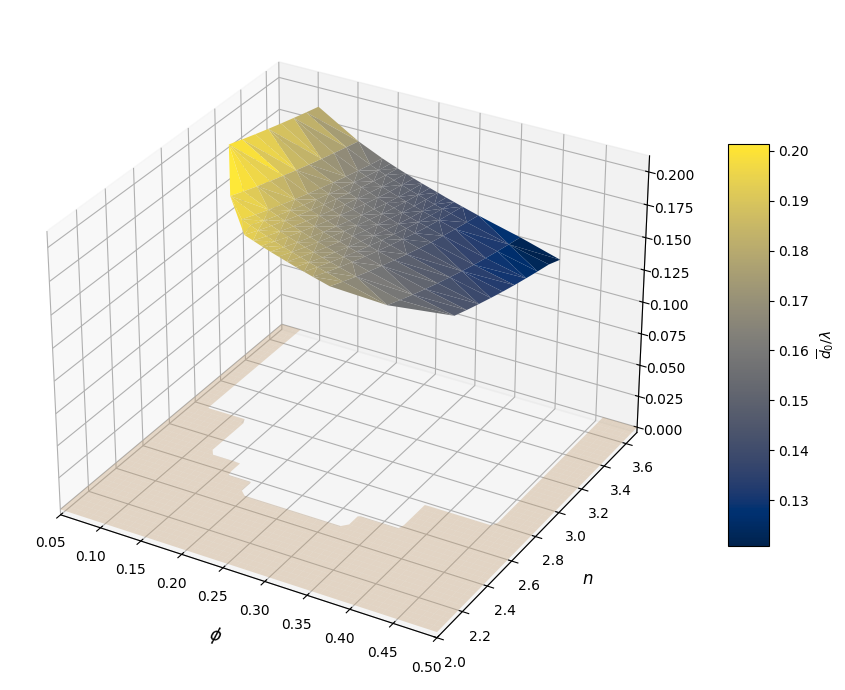

In [11]:
plot_3d_map_gap_position(gap_list,"Elliptical")


In [12]:
# Assuming /AutomationModule is in the root directory of your project
import sys
import os
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))
from AutomationModule import * 

import AutomationModule as AM

In [13]:
AM.create_hdf5_from_dict(gap_list,"bgw_list.h5")